In [1]:
import glob
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import keras
import random
import matplotlib.pyplot as plt
import datetime
import os
import time
from keras.models import Model
from keras.layers import (BatchNormalization, Input, Dense, Activation)
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow_probability as tfp
import seaborn as sns

pi = math.pi
maxval = 1e9
minval = 1e-9

In [2]:
train_df = pd.read_csv('train1Dy_df.csv')
test_df = pd.read_csv('test1Dy_df.csv')

In [3]:
def inverse_cot(cota):
    a = np.arctan(1/cota)
    a[np.where(a<0)] = a[np.where(a<0)]+pi
    return a

In [4]:
X_train = train_df.drop(columns=['y-local','y-midplane','cotBeta']).values
X_test = test_df.drop(columns=['y-local','y-midplane','cotBeta']).values

y_train = inverse_cot(abs(train_df['cotBeta'].values))/(pi/2)
y_test = inverse_cot(abs(test_df['cotBeta'].values))/(pi/2)

/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_58782/2672626872.py:2: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(1/cota)


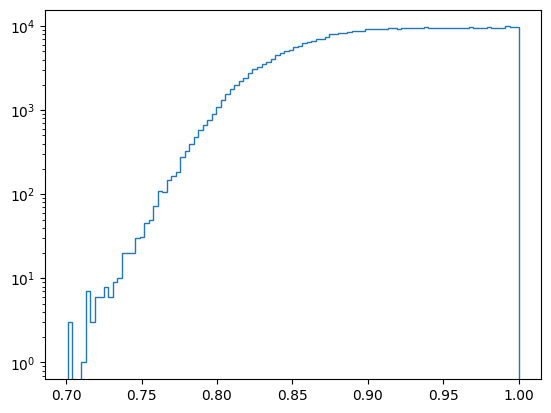

In [5]:
plt.hist(y_train,bins = 100, histtype = "step");
plt.yscale("log")
plt.show()

In [6]:
X_train = X_train.reshape(-1, X_train.shape[-1])
X_test = X_test.reshape(-1, X_test.shape[-1])
print(X_train.shape,X_test.shape)

(499818, 13) (75685, 13)


In [7]:
# def param_transform(par):
#     return minval+tf.math.softplus(par)

# def log_beta(x, alpha, beta):
#     # x in (0, 1), alpha > 0, beta > 0
#     return (alpha - 1.)*tf.math.log(x) + (beta - 1.)*tf.math.log(1 - x) \
#             - tf.math.lgamma(alpha) - tf.math.lgamma(beta) + tf.math.lgamma(alpha + beta)

# def beta_loss(y, p):
    
#     alpha = param_transform(tf.gather(params=p, indices=[0], axis=1))
#     beta = param_transform(tf.gather(params=p, indices=[1], axis=1))
    
# #     dist = tfp.distributions.Beta(concentration1 = alpha,
# #                                   concentration0 = beta)
    
# #     likelihood = dist.prob(y)  
# #     likelihood = tf.clip_by_value(likelihood,minval,maxval)

#     NLL = -1*log_beta(y, alpha, beta)
#     return tf.keras.backend.sum(NLL,axis=1)  
 
def param_transform(par):
    return minval+tf.math.softplus(par)

def beta_loss(y, p):
    
    alpha = param_transform(tf.gather(params=p, indices=[0], axis=1))
    beta = param_transform(tf.gather(params=p, indices=[1], axis=1))
    
    dist = tfp.distributions.Beta(concentration1 = alpha,
                                   concentration0 = beta)
    
    loglikelihood = dist.log_prob(y)  

    NLL = -1*loglikelihood
    return tf.keras.backend.mean(NLL,axis=1)  


def gauss_loss(y, p):
    
    maxval = 1e9
    minval = 1e-9
    pi = math.pi
    
    mu = param_transform(tf.gather(params=p, indices=[0], axis=1))
    sigma = param_transform(tf.gather(params=p, indices=[1], axis=1))
        
    likelihood = 1.0/tf.math.sqrt(2*pi)/sigma*tf.math.exp(-1*(y-mu)*(y-mu)/(2*sigma*sigma))
    likelihood = tf.clip_by_value(likelihood,minval,maxval)
    
    NLL = -1*tf.math.log(likelihood)
    
    return tf.keras.backend.sum(NLL,axis=1)

In [8]:
def CreateModel(shape):
    x = x_in = Input(shape)
    x = Dense(64, name="dense1")(x)
    x = Activation("relu", name="act1")(x)
    x = BatchNormalization()(x)
    x = Dense(64, name="dense2")(x)
    x = Activation("relu", name="act2")(x)
    x = BatchNormalization()(x)
    x = Dense(64, name="dense3")(x)
    x = Activation("relu", name= "act3")(x)
    x = BatchNormalization()(x)
    x = Dense(2, name="dense4")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

model=CreateModel(X_train.shape[1:])

model.compile(optimizer=Adam(learning_rate=0.0025),
              loss=gauss_loss)

print(model.summary())

def lr_schedule(epoch, lr):
    """
    Reduces the learning rate by 0.9 if the epoch % 10 == 0 that is for every 10th epoch.
    Args:
        epoch: Training epoch number
        lr: learning rate for the optimizer.
    Returns: Updated learning rate
    """
    if (epoch % 10) == 0 and epoch != 0:
        lr *= 0.9
    return lr

lr_decay = keras.callbacks.LearningRateScheduler (lr_schedule , verbose=10)
es = EarlyStopping(patience=5,
                   monitor = 'val_loss',
                   mode = 'min',
                  restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=50,
                    batch_size=512,
                    validation_split=0.1,
                    shuffle=True,
                    verbose=True)

Metal device set to: Apple M1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense1 (Dense)              (None, 64)                896       
                                                                 
 act1 (Activation)           (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense2 (Dense)              (None, 64)                4160      
                                                                 
 act2 (Activation)           (None, 64)                0         
                               

2023-02-14 17:05:19.411405: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-14 17:05:19.411422: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-14 17:05:19.583283: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-14 17:05:20.020663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


879/879 [==============================] - ETA: 0s - loss: -1.4100

2023-02-14 17:05:30.881409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


879/879 [==============================] - 12s 13ms/step - loss: -1.4100 - val_loss: -2.0812
Epoch 2/50
879/879 [==============================] - 11s 12ms/step - loss: -2.0158 - val_loss: -2.1900
Epoch 3/50
879/879 [==============================] - 11s 12ms/step - loss: -2.1045 - val_loss: -2.2893
Epoch 4/50
879/879 [==============================] - 11s 12ms/step - loss: -2.1476 - val_loss: -2.3068
Epoch 5/50
879/879 [==============================] - 11s 12ms/step - loss: -2.1764 - val_loss: -2.2516
Epoch 6/50
879/879 [==============================] - 11s 12ms/step - loss: -2.1971 - val_loss: -2.3516
Epoch 7/50
879/879 [==============================] - 11s 12ms/step - loss: -2.2147 - val_loss: -2.2470
Epoch 8/50
879/879 [==============================] - 11s 12ms/step - loss: -2.2062 - val_loss: -2.4377
Epoch 9/50
879/879 [==============================] - 11s 12ms/step - loss: -2.2216 - val_loss: -2.3857
Epoch 10/50
879/879 [==============================] - 11s 12ms/step - loss

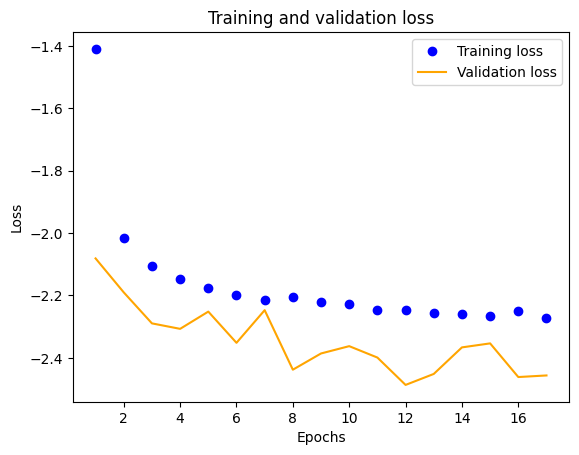

In [9]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.yscale('Log')
plt.legend()
plt.show()

In [10]:
p_test = model.predict(X_test)
df = pd.DataFrame(p_test,columns=['par1','par2'])
df['Btrue'] = y_test*pi/2
df['mu'] = param_transform(df['par1'])*pi/2
df['sigma'] = param_transform(df['par1'])*pi/2
df
# dist = tfp.distributions.Beta(concentration1 = df['alpha'], concentration0 = df['beta'])
    
# df['mean'] = dist.mean()*pi/2
# df['mode'] = dist.mode()*pi/2
# df['sigma'] = dist.stddev()*pi/2

  44/2366 [..............................] - ETA: 5s

2023-02-14 17:08:24.972636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2366/2366 [==============================] - 6s 2ms/step


,par1,par2,Btrue,mu,sigma
0,0.455194,-4.073684,1.501159,1.486639,1.486639
1,0.463490,-4.066065,1.480066,1.494626,1.494626
2,0.408051,-3.821602,1.443849,1.441744,1.441744
3,0.413600,-4.023191,1.419830,1.446986,1.446986
4,0.247913,-3.678338,1.276394,1.295540,1.295540
...,...,...,...,...,...
75680,0.484532,-3.682435,1.490681,1.514997,1.514997
75681,0.480650,-3.783325,1.538514,1.511226,1.511226
75682,0.498818,-3.638878,1.512850,1.528921,1.528921
75683,0.452535,-3.944484,1.489867,1.484085,1.484085


Text(0, 0.5, '$\\sigma$')

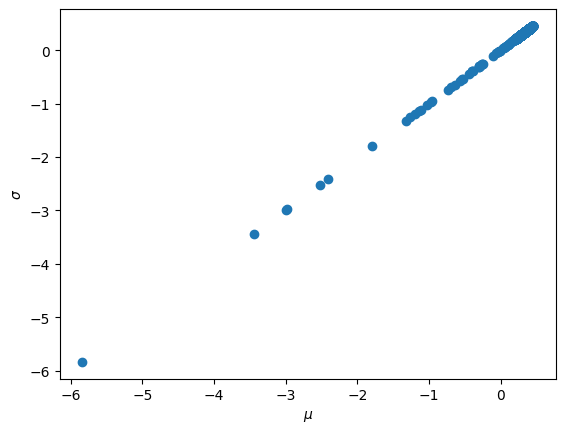

In [12]:
plt.scatter(np.log(df['mu']),np.log(df['sigma']))
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')

In [13]:
#residuals = df['Btrue'] - df['mode']
residuals = df['Btrue'] - df['mu']
print(np.mean(residuals),np.std(residuals))

0.004286678021007448 0.03797244679904359


/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_58782/2267952060.py:2: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


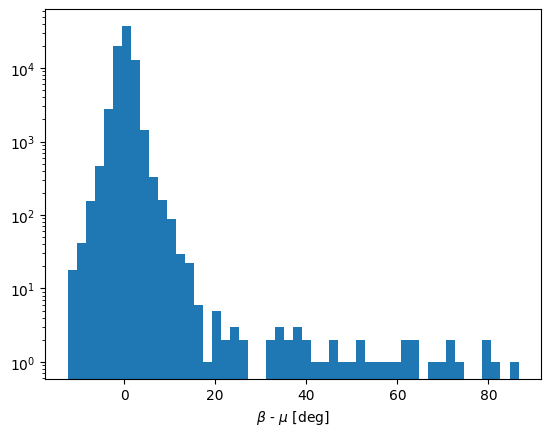

/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_58782/2267952060.py:7: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


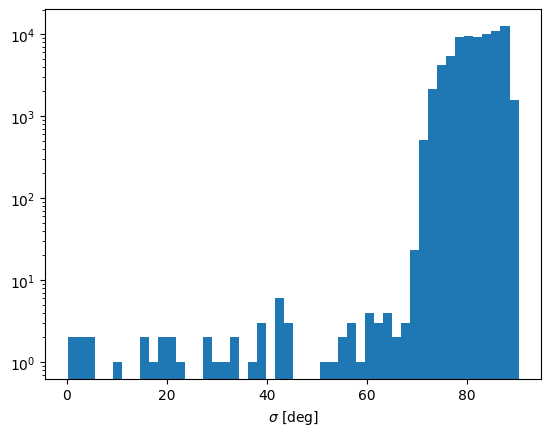

In [14]:
plt.hist(residuals*180/pi,bins=50)
plt.yscale('Log')
plt.xlabel(r'$\beta$ - $\mu$ [deg]')
plt.show()

plt.hist(df['sigma']*180/pi,bins=50);
plt.yscale('Log')
plt.xlabel(r'$\sigma$ [deg]')
plt.show()

0.01197397181454714 1.8991146467351916


Text(0.5, 0, 'pull')

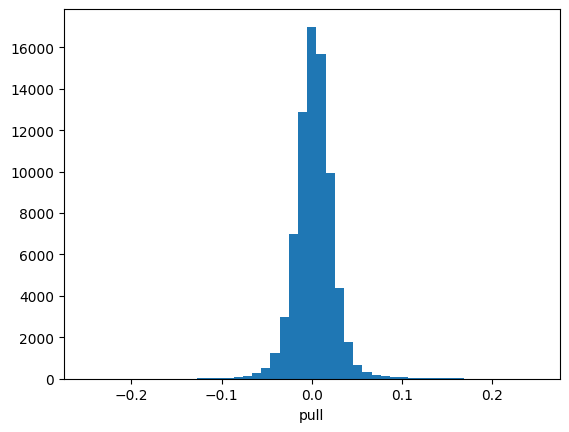

In [15]:
pulls = residuals/df['sigma']
print(np.mean(pulls),np.std(pulls))
plt.hist(pulls,bins=np.linspace(-0.25,0.25,50))
plt.xlabel('pull')

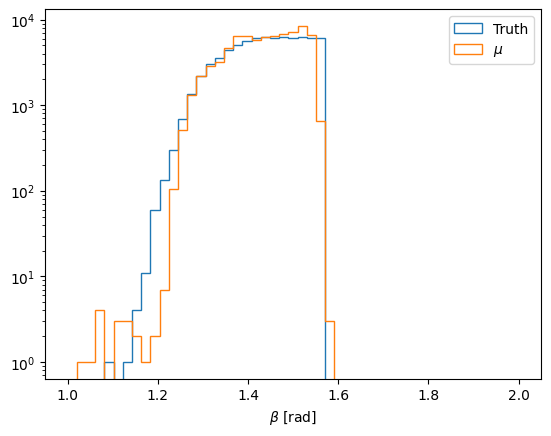

In [16]:
plt.hist(df["Btrue"], bins = np.linspace(1,2,50), histtype = "step")
plt.hist(df["mu"], bins = np.linspace(1,2,50), histtype = "step")
plt.xlabel(r'$\beta$ [rad]')
plt.legend(["Truth", r'$\mu$'])
plt.yscale('log')
plt.show()

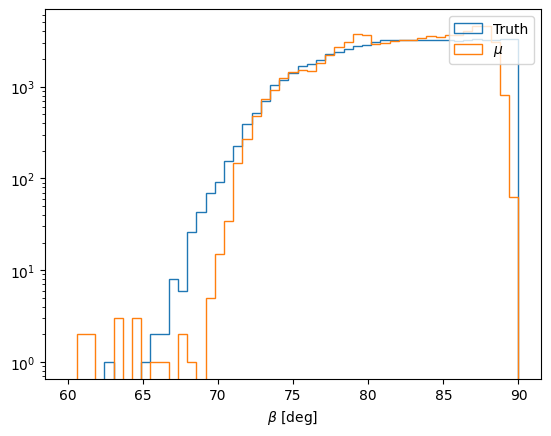

In [17]:
plt.hist(df["Btrue"]*180/pi, bins = np.linspace(60,90,50), histtype = "step")
plt.hist(df["mu"]*180/pi, bins = np.linspace(60,90,50), histtype = "step")
plt.xlabel(r'$\beta$ [deg]')
plt.legend(["Truth", r'$\mu$'])
plt.yscale('log')
plt.show()

Text(0, 0.5, '$\\beta$ - $\\mu$ [rad]')

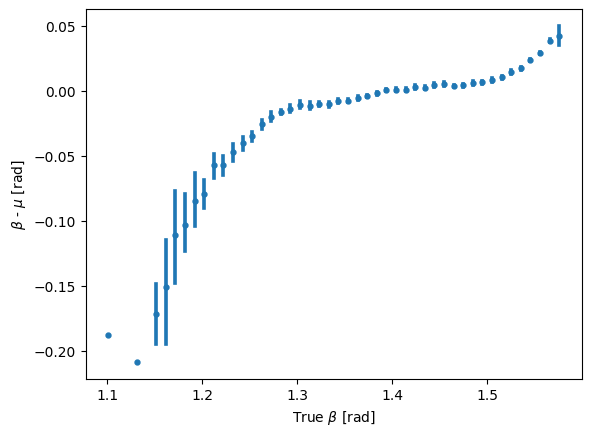

In [18]:
x = sns.regplot(x=df['Btrue'], y=df['Btrue']-df['mu'], x_bins=np.linspace(1,2,100), fit_reg=None, marker='.')
plt.xlabel(r'True $\beta$ [rad]')
plt.ylabel(r'$\beta$ - $\mu$ [rad]')

Text(0, 0.5, '$\\sigma$ [rad]')

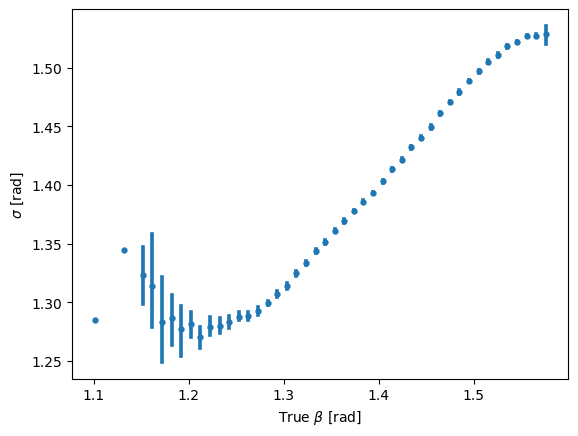

In [19]:
y = sns.regplot(x=df['Btrue'], y=df['sigma'], x_bins=np.linspace(1,2,100), fit_reg=None, marker='.')
plt.xlabel(r'True $\beta$ [rad]')
plt.ylabel(r'$\sigma$ [rad]')